In [510]:
import os,cv2
import matplotlib.pyplot as plt
import numpy as npy
import h5py
import mahotas
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [512]:
def hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [511]:
train_path = ('./swedish dataset/')

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

bins             = 8
# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']


In [513]:
# loop over the training data sub-folders
for training_name in train_labels:
    
    # join the training data path and each species training folder
    image_list = os.listdir(train_path+'/'+training_name)
    
    #print('Images folder loaded '+'{}\n'.format(training_name))
    # get the current training label
    current_label = training_name 
    
    # loop over the images in each sub-folder
    for image in image_list:
        # get the image file name
        
        # read the image and resize it to a fixed-size
        image = cv2.imread(train_path + '/' + training_name +'/'+ image)
        image = cv2.resize(image,(300,300))

        ####################################
        # Global Feature extraction
        ####################################
        fv_hu_moments = hu_moments(image)
        fv_haralick   = haralick(image)
        fv_histogram  = histogram(image)

        ###################################
        # Concatenate global features
        ###################################
        global_feature = npy.hstack([fv_haralick, fv_hu_moments,fv_histogram])
        #global_feature = fv_hu_moments
        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: A
[STATUS] processed folder: B
[STATUS] processed folder: C
[STATUS] processed folder: D
[STATUS] processed folder: E
[STATUS] processed folder: F
[STATUS] processed folder: G
[STATUS] processed folder: H
[STATUS] processed folder: I
[STATUS] processed folder: J
[STATUS] processed folder: K
[STATUS] processed folder: L
[STATUS] processed folder: M
[STATUS] processed folder: N
[STATUS] processed folder: O
[STATUS] completed Global Feature Extraction...


In [514]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(npy.array(global_features).shape))

[STATUS] feature vector size (1110, 20)


In [515]:
import pandas as pd
pd.set_option('display.max_rows', None)

In [516]:
# get the overall training label size
print("[STATUS] training Labels {}".format(npy.array(labels).shape))

[STATUS] training Labels (1110,)


In [517]:
# encode the target labels
targetNames = npy.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [518]:
# scale features in the range (0-1)
#scaler            = MinMaxScaler(feature_range=(0, 1))
#rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] feature vector normalized...
[STATUS] target labels: [ 0  0  0 ... 14 14 14]
[STATUS] target labels shape: (1110,)


In [519]:
df_fv = pd.DataFrame(global_features)

In [520]:
df.head()
#print(df_fv)

,0,1,2,3,4,5,6
0,0.001331,3.713683e-09,3.193577e-13,3.847192e-13,-5.354778e-26,2.116719e-18,-1.237637e-25
1,0.001322,2.380683e-09,3.297965e-13,1.611919e-12,-8.885813e-25,-2.416800e-17,-7.692103e-25
2,0.001224,1.018577e-09,3.120967e-13,8.453160e-14,1.289957e-26,-1.025176e-18,4.702795e-27
3,0.001220,1.248863e-09,3.279303e-13,2.077665e-12,1.610208e-24,3.151610e-17,5.901874e-25
4,0.001227,7.150219e-10,5.056845e-14,1.652142e-12,3.430323e-25,-2.278620e-17,3.322268e-25


In [521]:
df_label = pd.DataFrame(target)
df_label.head(10)
#print(df_label)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [522]:
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC

In [523]:
# split the training and testing data
(X_train, X_test, y_train, y_test) = train_test_split(npy.array(global_features),
                                                      npy.array(target),
                                                      test_size=0.1,
                                                      random_state=42)

In [524]:
print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(X_train.shape))
print("Test data   : {}".format(X_test.shape))
print("Train labels: {}".format(y_train.shape))
print("Test labels : {}".format(y_test.shape))

[STATUS] splitted train and test data...
Train data  : (999, 20)
Test data   : (111, 20)
Train labels: (999,)
Test labels : (111,)


In [525]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [526]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [527]:
results =[]
kfold = KFold(n_splits=3, random_state=42)
cv_results = cross_val_score(clf, X_train, y_train, cv=kfold, scoring="accuracy")
print(cv_results)

[0.76576577 0.7957958  0.74474474]


In [528]:
name = "Random Forest"
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

Random Forest: 0.768769 (0.020949)


In [529]:
#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
train_path = "swedish dataset"
test_path  = "swedish dataset test"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

data_directory_test = os.listdir(test_path)

#-----------------------------------#


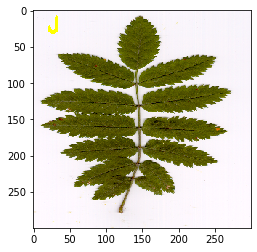

class: 9
file: l10nr075.tif
#-----------------------------------#


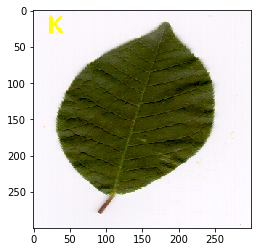

class: 10
file: l11nr075.tif
#-----------------------------------#


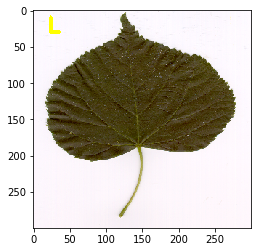

class: 11
file: l12nr075.tif
#-----------------------------------#


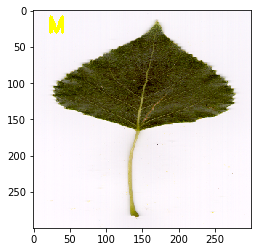

class: 12
file: l13nr075.tif
#-----------------------------------#


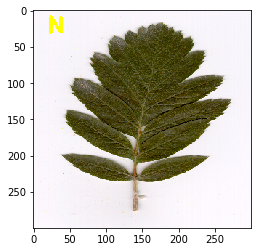

class: 13
file: l14nr075.tif
#-----------------------------------#


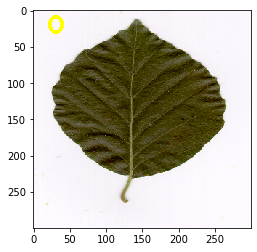

class: 14
file: l15nr075.tif
#-----------------------------------#


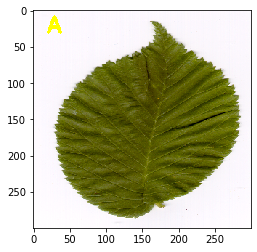

class: 0
file: l1nr075.tif
#-----------------------------------#


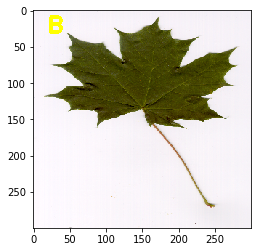

class: 1
file: l2nr075.tif
#-----------------------------------#


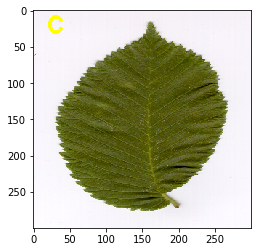

class: 2
file: l3nr075.tif
#-----------------------------------#


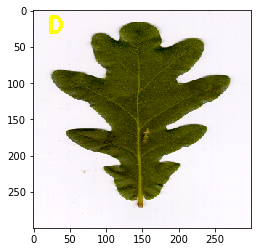

class: 3
file: l4nr075.tif
#-----------------------------------#


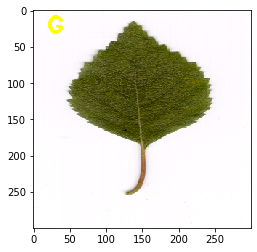

class: 6
file: l5nr075.tif
#-----------------------------------#


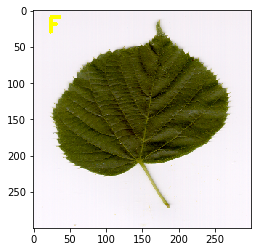

class: 5
file: l6nr001.tif
#-----------------------------------#


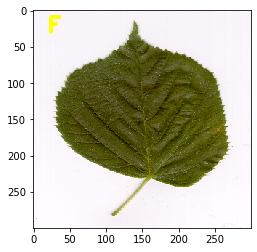

class: 5
file: l6nr075.tif
#-----------------------------------#


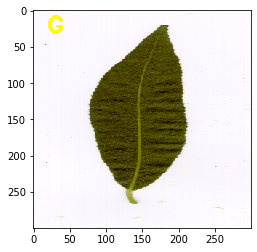

class: 6
file: l7nr075.tif
#-----------------------------------#


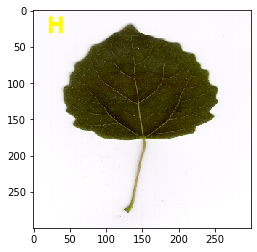

class: 7
file: l8nr075.tif
#-----------------------------------#


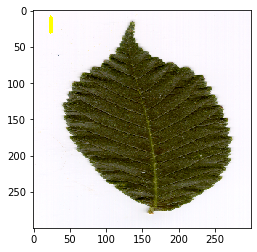

class: 8
file: l9nr075.tif
#-----------------------------------#


In [542]:
print("#-----------------------------------#")
# loop through the test images
for file in data_directory_test:
    
    # read the image
    image = cv2.imread(test_path+'/'+ file)

    # resize the image
    image = cv2.resize(image, (300,300))

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = hu_moments(image)
    fv_haralick   = haralick(image)
    #fv_histogram  = histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = npy.hstack([fv_haralick, fv_hu_moments])
    #global_feature = fv_hu_moments
    # scale features in the range (0-1)
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #rescaled_feature = scaler.fit_transform(global_feature.reshape(-1, 1))

    # predict label of test image
    prediction = clf.predict(global_feature.reshape(1,-1))[0]

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    print("class:",prediction)
    print("file:",file)
    print("#-----------------------------------#")